In [4]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from us_state_abbrev import *
from statsmodels.sandbox.distributions.multivariate import multivariate_t_rvs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

alpha = 1.0
cmap = plt.get_cmap('brg')
idx = pd.IndexSlice
tf = 2040

In [5]:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU
df = pd.read_csv('1976-2018-senate.csv', encoding='ISO-8859-1', index_col=0)
df.loc[(df.index == 1984) & (df['candidate'] == 'Mitch McConnell'), 'party'] = 'republican'
senate = df.pivot_table(values='candidatevotes', columns=['state_po', 'party'], index='year', aggfunc=np.sum)
senate.head()

state_po                 AK                                                  \
party    alaska libertarian alaskan independence democrat green independent   
year                                                                          
1976                    NaN                  NaN      NaN   NaN         NaN   
1978                    NaN                  NaN  29574.0   NaN         NaN   
1980                    NaN                  NaN  72007.0   NaN         NaN   
1982                    NaN                  NaN      NaN   NaN         NaN   
1984                    NaN                  NaN  58804.0   NaN         NaN   

state_po                                                             \
party    libertarian no party affiliation nonaffiliated nonpartisan   
year                                                                  
1976             NaN                  NaN           NaN         NaN   
1978             NaN                  NaN           NaN         NaN   
1980             NaN                  NaN           NaN         NaN   
1982             NaN                  NaN           NaN         NaN   
1984             NaN                  NaN           NaN         NaN   

state_po             ...       WV                                              \
party    republican  ... mountain mountain party republican socialist workers   
year                 ...                                                        
1976            NaN  ...      NaN            NaN        NaN               NaN   
1978        92783.0  ...      NaN            NaN   244317.0               NaN   
1980        84159.0  ...      NaN            NaN        NaN               NaN   
1982            NaN  ...      NaN            NaN   173910.0            4234.0   
1984       146919.0  ...      NaN            NaN   344680.0            3299.0   

state_po            WY                                                          
party    country party democrat independent libertarian natural law republican  
year                                                                            
1976               NaN  70558.0         NaN         NaN         NaN    84810.0  
1978               NaN  82908.0         NaN         NaN         NaN    50456.0  
1980               NaN      NaN         NaN         NaN         NaN        NaN  
1982               NaN  72466.0         NaN         NaN         NaN    94725.0  
1984               NaN  40525.0         NaN         NaN         NaN   146373.0  

[5 rows x 548 columns]

In [6]:
states = list(senate.columns.levels[0])
senate_lean = pd.DataFrame(index=senate.index, columns=states)
for state in states:
    df = senate.loc[:, idx[state, :]].dropna(how='all')
    for year in df.index:
        s = df.loc[year].sort_values(ascending=False)
        winner = s.index.get_level_values(1)[0]
        if winner in ['democrat', 'republican']:
            sign = 1.0 if winner == 'democrat' else -1.0
        else:
            loser = s.index.get_level_values(1)[1]
            sign = -1.0 if loser == 'democrat' else 1.0
        senate_lean.loc[year, state] = sign*100.0*(s.iloc[0] - s.iloc[1])/s.sum()

In [429]:
t0 = senate_lean.index[0]
senate_proj = pd.DataFrame(index=np.arange(senate_lean.index[0], tf + 1, 1), columns=senate_lean.columns)
X_pred = np.array(senate_proj.index).reshape(-1, 1).astype(float)
senate_results = {}
for i in range(len(senate_proj.columns)):  
    state = senate_proj.columns[i]
    df = senate_lean[state].dropna()
    X = np.array(df.index).reshape(-1, 1).astype(float)
    y = df.values.astype(float)
    
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
#     results = model.fit(cov_type='HC1', use_t=True)
    y_pred = results.predict(sm.add_constant(X_pred))
    senate_proj[state] = y_pred
    senate_results[state] = results

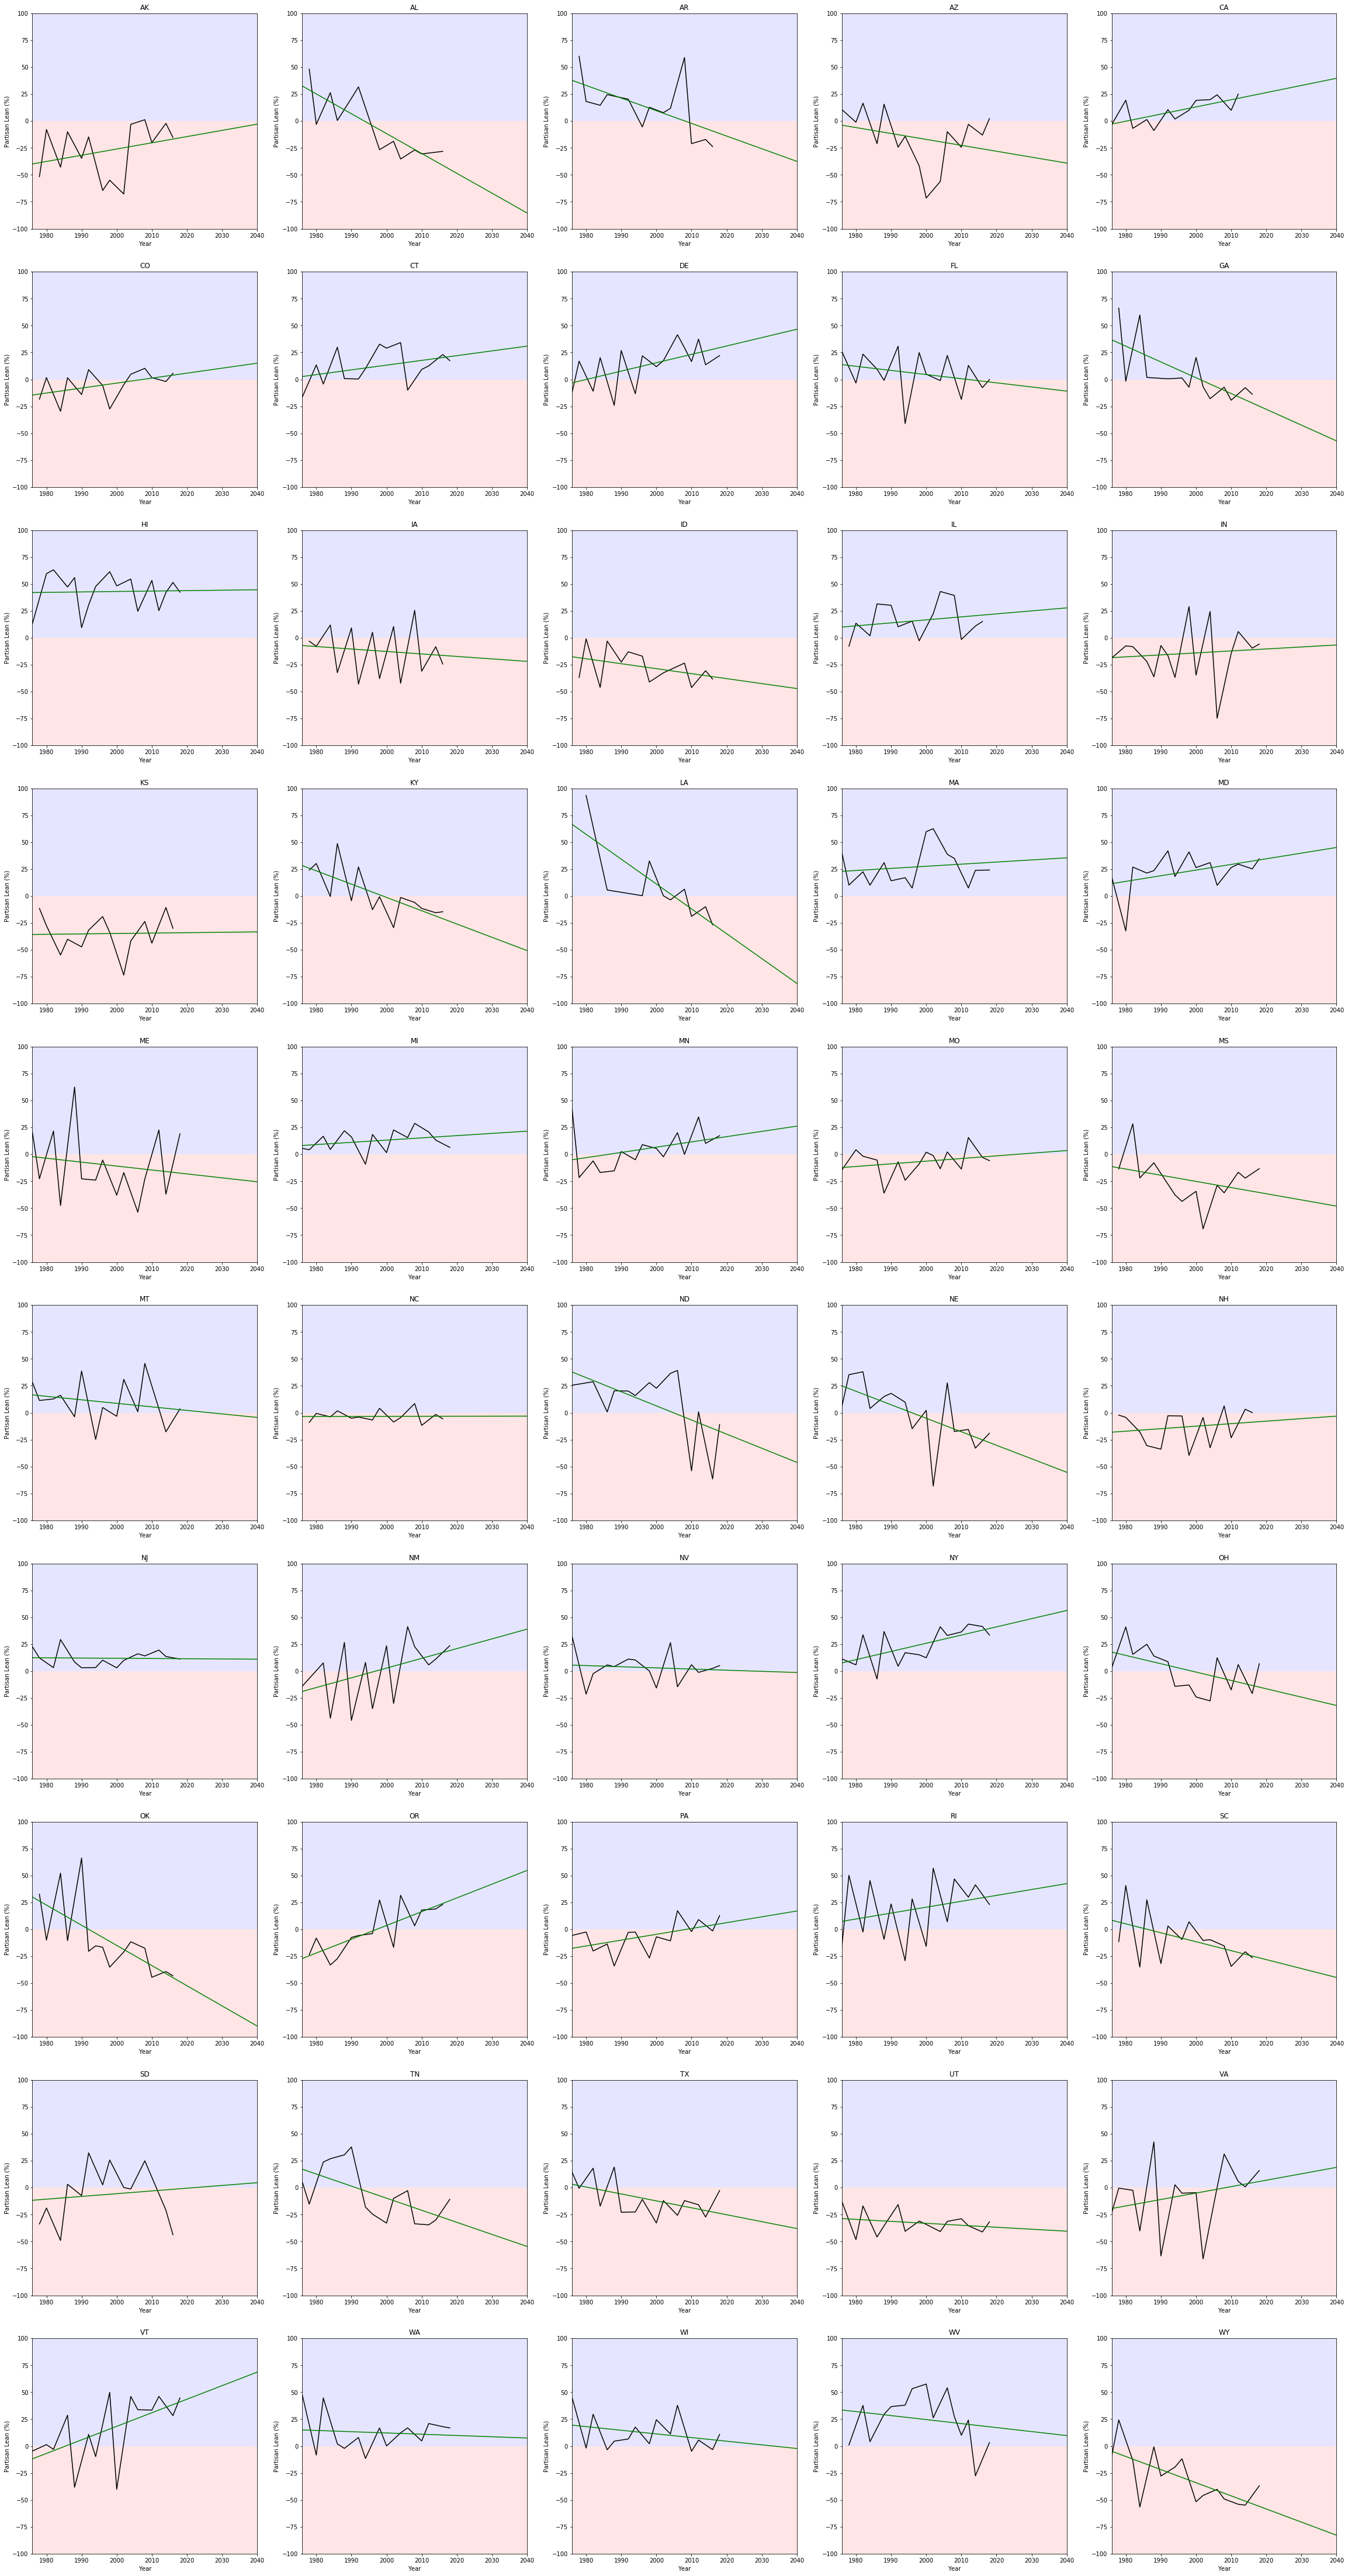

In [430]:
shape = (10, 5)
fig, ax = plt.subplots(shape[0], shape[1], figsize=(40, 80))
for i in range(len(senate_proj.columns)):
    axi = ax[np.unravel_index(i, shape)]
    state = senate_proj.columns[i]
    df = senate_lean[state].dropna()
    df.plot(ax=axi, color='k')
    senate_proj[state].plot(ax=axi, color='g')
    axi.set_title(state)
#     axi.grid()
    axi.set_xlabel('Year')
    axi.set_ylabel('Partisan Lean (%)')
    axi.axhspan(0, 100, facecolor='b', alpha=0.1)
    axi.axhspan(-100, 0, facecolor='r', alpha=0.1)
    axi.set_ylim(-100, 100)

In [431]:
n = 1000
state_plot = 'VA'
x_plot = pd.DataFrame(index=senate_proj.index, columns=range(n))
senate_prob = pd.DataFrame(index=senate_proj.index, columns=senate_proj.columns)
for state in senate_prob.columns:
    results = senate_results[state]
    for year in senate_prob.index:
        s = multivariate_t_rvs(results.params, results.cov_params(), results.df_resid, n)
        x = (year)*s[:, 1] + s[:, 0]
        if state == state_plot:
            x_plot.loc[year] = x
        senate_prob.loc[year, state] = 100.0*np.sum(x >= 0)/n
#     break

In [432]:
r = senate_results[state_plot]
print(r.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9727
Date:                Sun, 16 Feb 2020   Prob (F-statistic):              0.342
Time:                        22:34:10   Log-Likelihood:                -71.444
No. Observations:                  15   AIC:                             146.9
Df Residuals:                      13   BIC:                             148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1199.9189   1209.531     -0.992      0.3

In [433]:
rr = results.get_robustcov_results()
print(rr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     9.703
Date:                Sun, 16 Feb 2020   Prob (F-statistic):            0.00821
Time:                        22:34:10   Log-Likelihood:                -63.833
No. Observations:                  15   AIC:                             131.7
Df Residuals:                      13   BIC:                             133.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2404.8379    784.295      3.066      0.0

In [434]:
results.cov_params()

array([[ 5.30277321e+05, -2.65587822e+02],
       [-2.65587822e+02,  1.33024487e-01]])

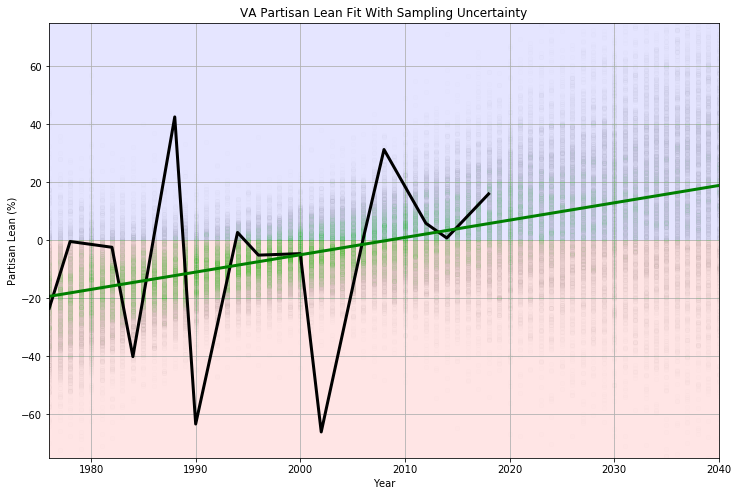

In [435]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c = 0.75
x_plot.plot(ax=ax, legend=False, marker='o', markersize=5, color=[(0.0, c, 0.0, 1/256)], linewidth=0)
df = senate_lean[state_plot].dropna()
df.plot(ax=ax, color='k', linewidth=3)
senate_proj[state_plot].plot(ax=ax, color='g', linewidth=3)
ax.set_title(state_plot)
ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Partisan Lean (%)')
ax.set_title('%s Partisan Lean Fit With Sampling Uncertainty' % state_plot)
ax.set_ylim([-75, 75])
ax.axhspan(0, 100, facecolor='b', alpha=0.1)
ax.axhspan(-100, 0, facecolor='r', alpha=0.1)

65.7
6.139827976380655


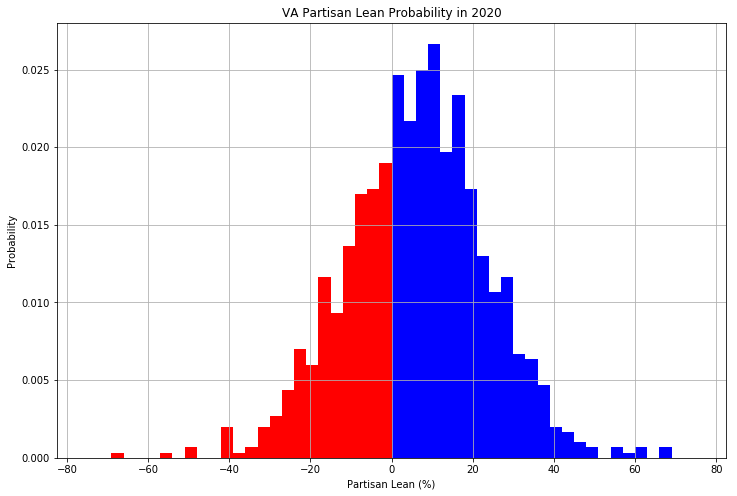

In [436]:
year = 2020
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bins = np.linspace(-75, 75, 51)
N, _, patches = ax.hist(x_plot.loc[year].astype(float), bins=bins, density=True)
ax.grid()

for i in range(len(patches)):
    if bins[i] < 0.0:
        patches[i].set_facecolor('r')
    else:
        patches[i].set_facecolor('b')
ax.set_xlabel('Partisan Lean (%)')
ax.set_ylabel('Probability')
ax.set_title('%s Partisan Lean Probability in %d' % (state_plot, year))
print(senate_prob.loc[year, state_plot])
print(x_plot.loc[year].mean())

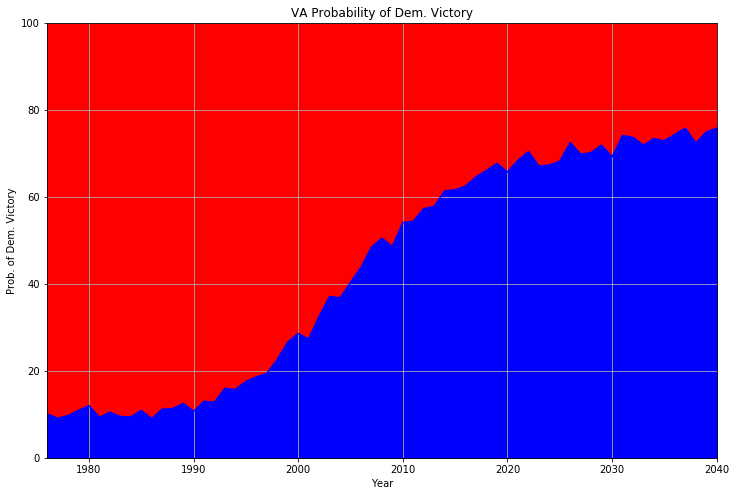

In [437]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(12, 8))
state = senate_proj.columns[i]
senate_prob[state_plot].plot.area(ax=ax, color='b')

ax.set_title(state_plot)
ax.set_xlabel('Year')
ax.set_ylabel('Prob. of Dem. Victory')
ax.set_ylim([0, 100])
ax.set_facecolor('r')
ax.set_title('%s Probability of Dem. Victory' % state_plot)
ax.grid()

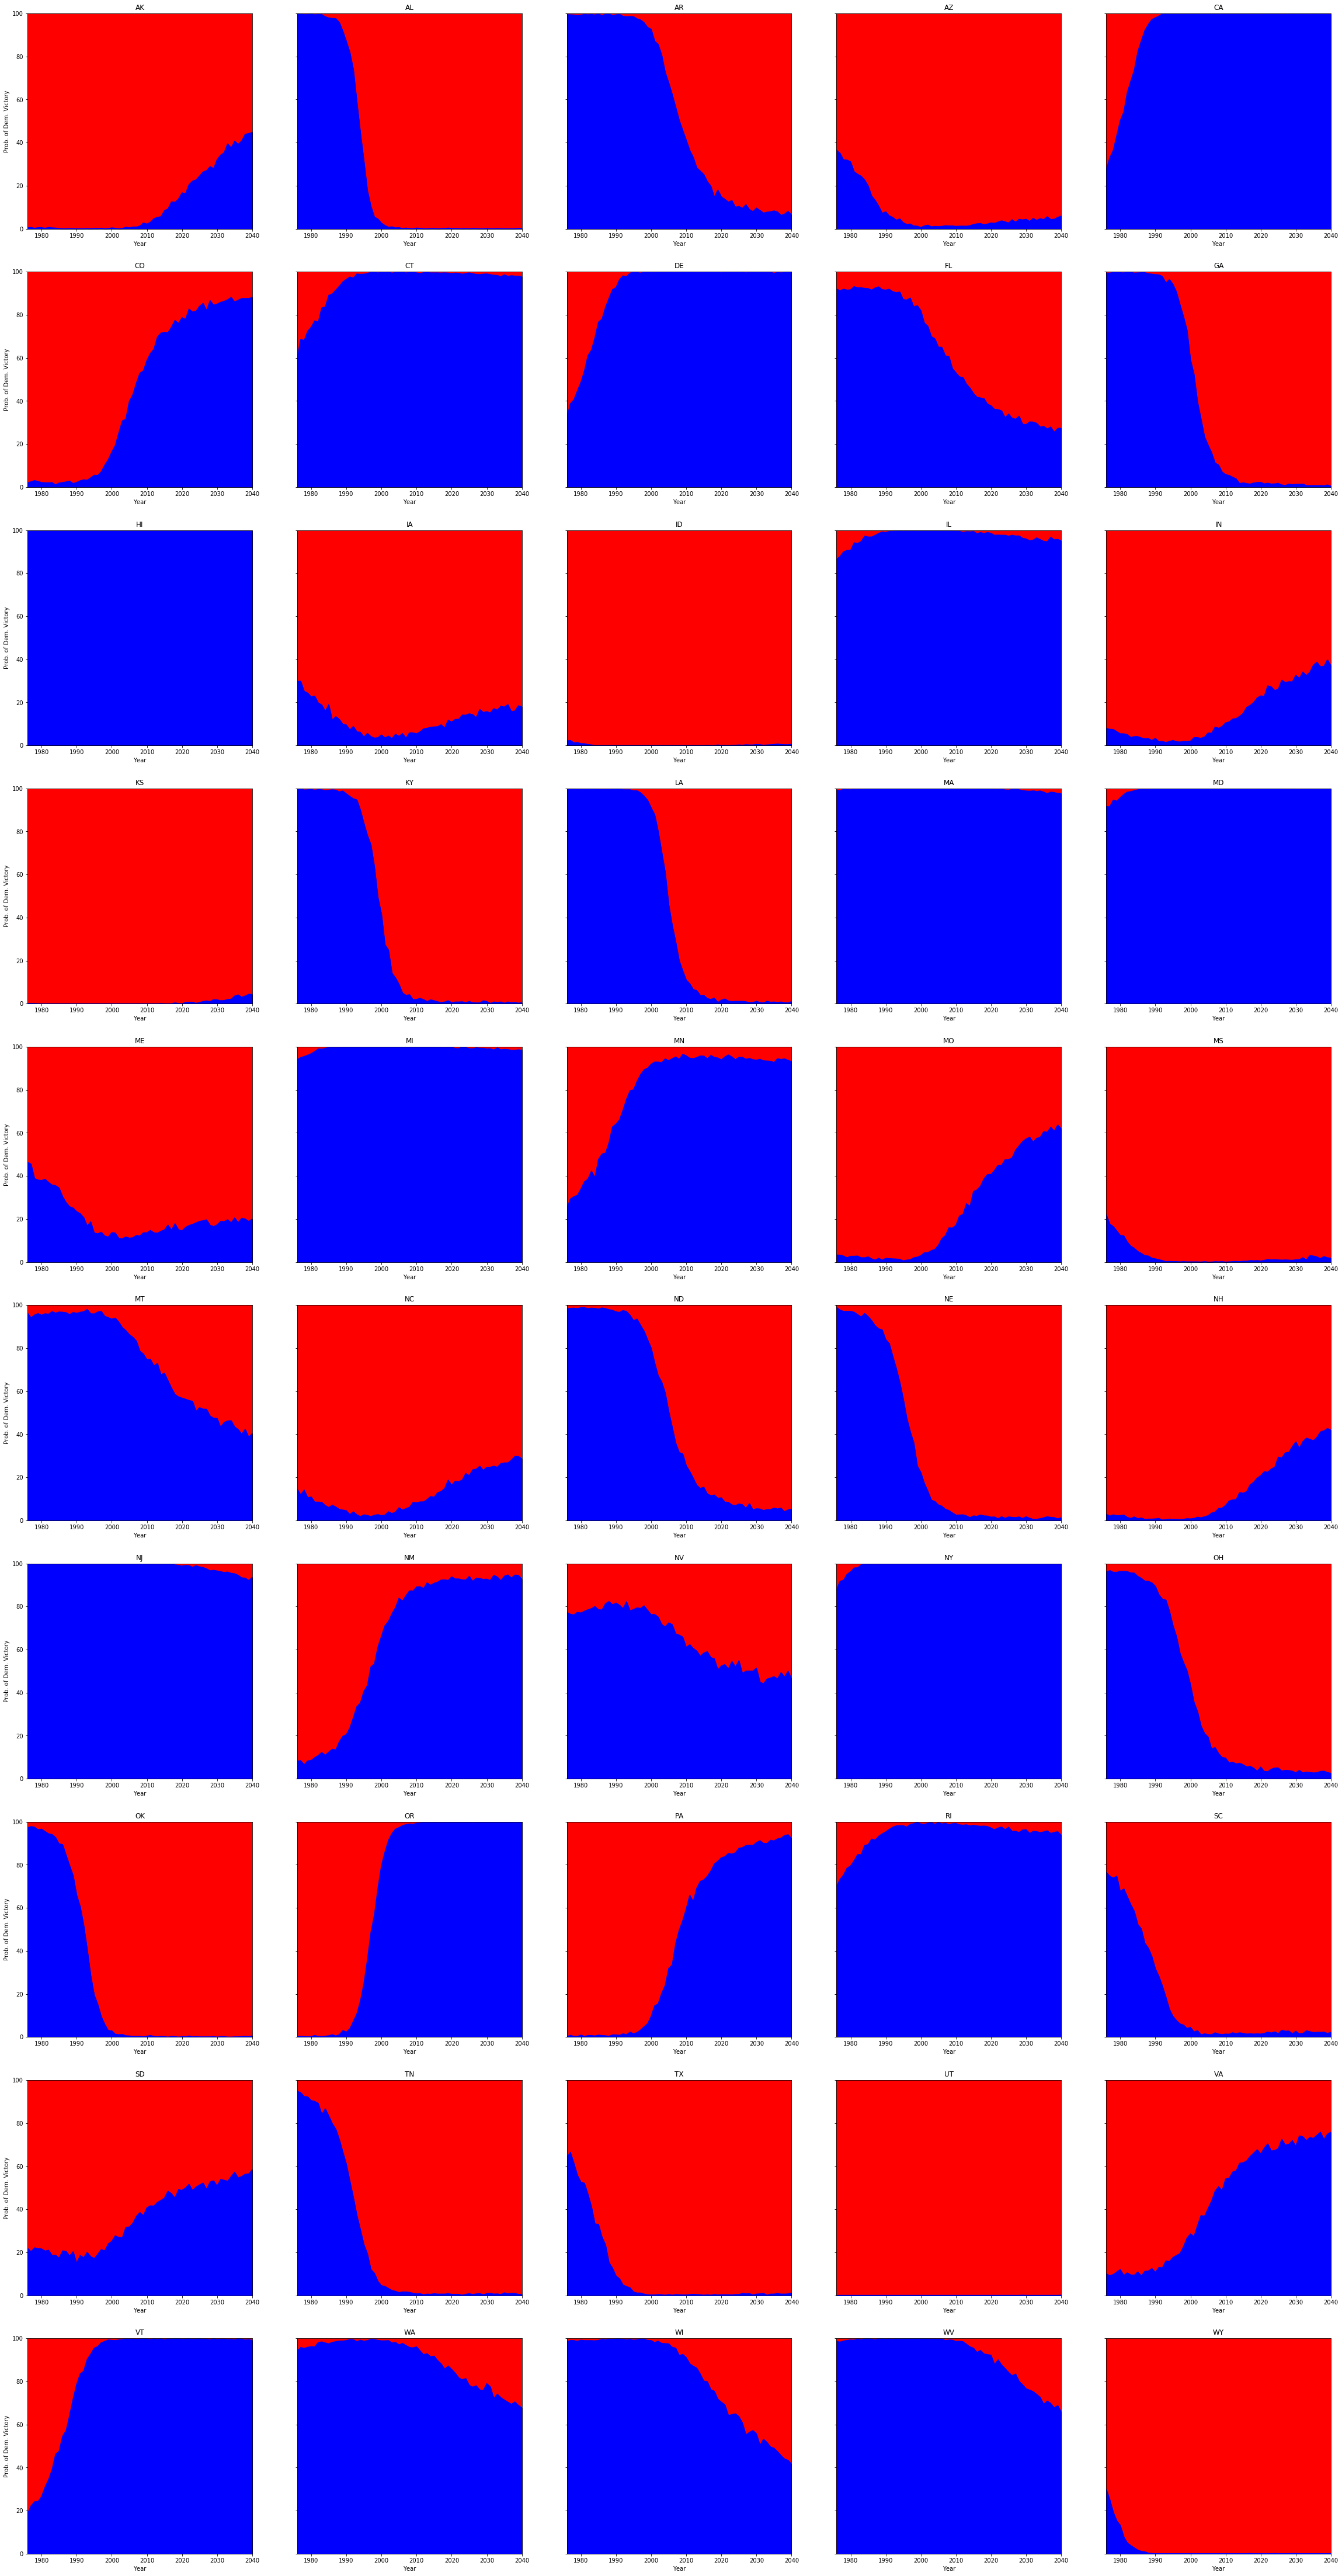

In [438]:
shape = (10, 5)
fig, ax = plt.subplots(shape[0], shape[1], sharey=True, figsize=(40, 80))
for i in range(len(senate_prob.columns)):
    axi = ax[np.unravel_index(i, shape)]
    state = senate_proj.columns[i]
    senate_prob[state].plot.area(ax=axi, color='b')
    
    axi.set_title(state)
    axi.set_xlabel('Year')
    axi.set_ylabel('Prob. of Dem. Victory')
    axi.set_ylim([0, 100])
    axi.set_facecolor('r')

0.066
0.061
46.658


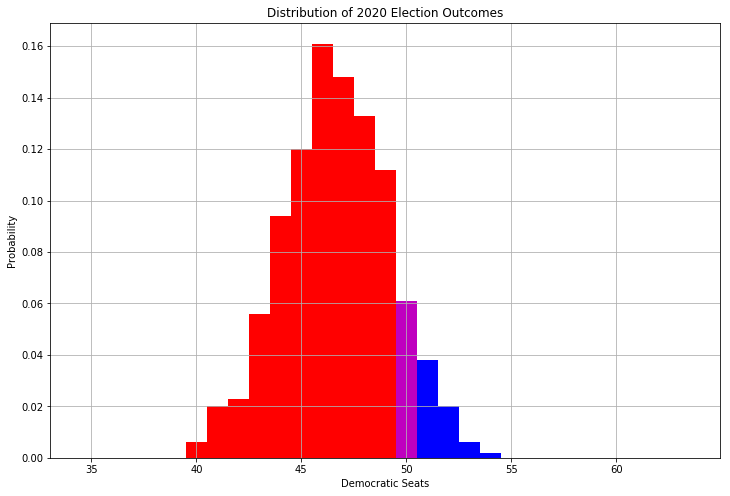

In [439]:
n = 1000
year = 2020
x = np.zeros(n)
for i in range(n):
    x[i] = (senate_prob.loc[year] > np.random.random(len(senate_prob.columns))*100).sum() + (senate_prob.loc[year] > np.random.random(len(senate_prob.columns))*100).sum()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(35, 65, 1)
N, _, patches = ax.hist(x, bins=bins, density=True, align='left', histtype='bar')
ax.grid()

for i in range(len(patches)):
    if bins[i] < 50:
        patches[i].set_facecolor('r')
    elif bins[i] == 50:
        patches[i].set_facecolor('m')
    else:
        patches[i].set_facecolor('b')
ax.set_xlabel('Democratic Seats')
ax.set_ylabel('Probability')
ax.set_title('Distribution of %d Election Outcomes' %  year)
# ax.set_xlim([20, 80])
print((x > 50).sum()/n)
print((x == 50).sum()/n)
print(x.mean())

In [440]:
(x == bins[0]).sum()

0

In [441]:
p = patches[0]
p.get_height()

0.0

In [442]:
# senate_proj.loc[2020]

In [443]:
# senate.loc[:, idx[:,'other']]
# mask = [p not in parties for p in senate.columns.get_level_values(1)]
# senate.loc[:, idx[:, :]].groupby(level=0, axis=1).sum()

In [444]:
# https://research.stlouisfed.org/pdl/628/download
df = pd.read_csv('State_Populations_Annual.txt', sep='\t', index_col=0, parse_dates=[0])
columns = df.columns.str.replace('POP', '')
pop = pd.DataFrame(df.values, index=df.index, columns=columns)
pop['US'] = pop.sum(axis=1)
pop.index = pop.index.year
pop.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,US
DATE,,,,,,,,,,,,,,,,,,,,,
1900,NaN,1830.0,1314.0,124.0,1490.0,543.0,910.0,278.0,185.0,530.0,...,2023.0,3055.0,277.0,1858.0,344.0,523.0,2072.0,959.0,93.0,76095.0
1901,NaN,1907.0,1341.0,131.0,1550.0,581.0,931.0,285.0,187.0,544.0,...,2041.0,3132.0,284.0,1887.0,347.0,583.0,2109.0,972.0,100.0,77588.0
1902,NaN,1935.0,1360.0,138.0,1623.0,621.0,952.0,290.0,188.0,565.0,...,2060.0,3210.0,292.0,1894.0,349.0,651.0,2141.0,1000.0,105.0,79160.0
1903,NaN,1957.0,1384.0,144.0,1702.0,652.0,972.0,295.0,190.0,587.0,...,2082.0,3291.0,299.0,1890.0,350.0,719.0,2171.0,1037.0,108.0,80631.0
1904,NaN,1978.0,1419.0,151.0,1792.0,659.0,987.0,302.0,192.0,599.0,...,2086.0,3374.0,308.0,1889.0,353.0,782.0,2202.0,1064.0,111.0,82165.0


In [445]:
# https://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth
def pend(y, t, r, k):
    dydt = r*y*(1 - y/k)
    return dydt

def func(t, p, r, k):
    return np.squeeze(odeint(pend, p, t, args=(r, k)))

In [446]:
pop_proj = pd.DataFrame(index=np.arange(pop.index[0], tf + 1, 1), columns=pop.columns)
for i in range(len(pop_proj.columns)):  
    col = pop_proj.columns[i]
    s = pop[col].dropna()
    t0 = s.index[0]
    t = np.array(s.index)
    y = s.values
    
    popt, pcov = curve_fit(func, t - t0, y, p0=[y[0], 0.01, y[0]])# , bounds=(0, (1.5*y[0], 0.1, 2*y[-1])))
#     print('%s: %s' % (col, str(popt)))
    t_pred = np.arange(t0, tf + 1, 1)
    y_pred = func(t_pred - t0, *popt)
    pop_proj[col] = pd.Series(y_pred, index=t_pred)

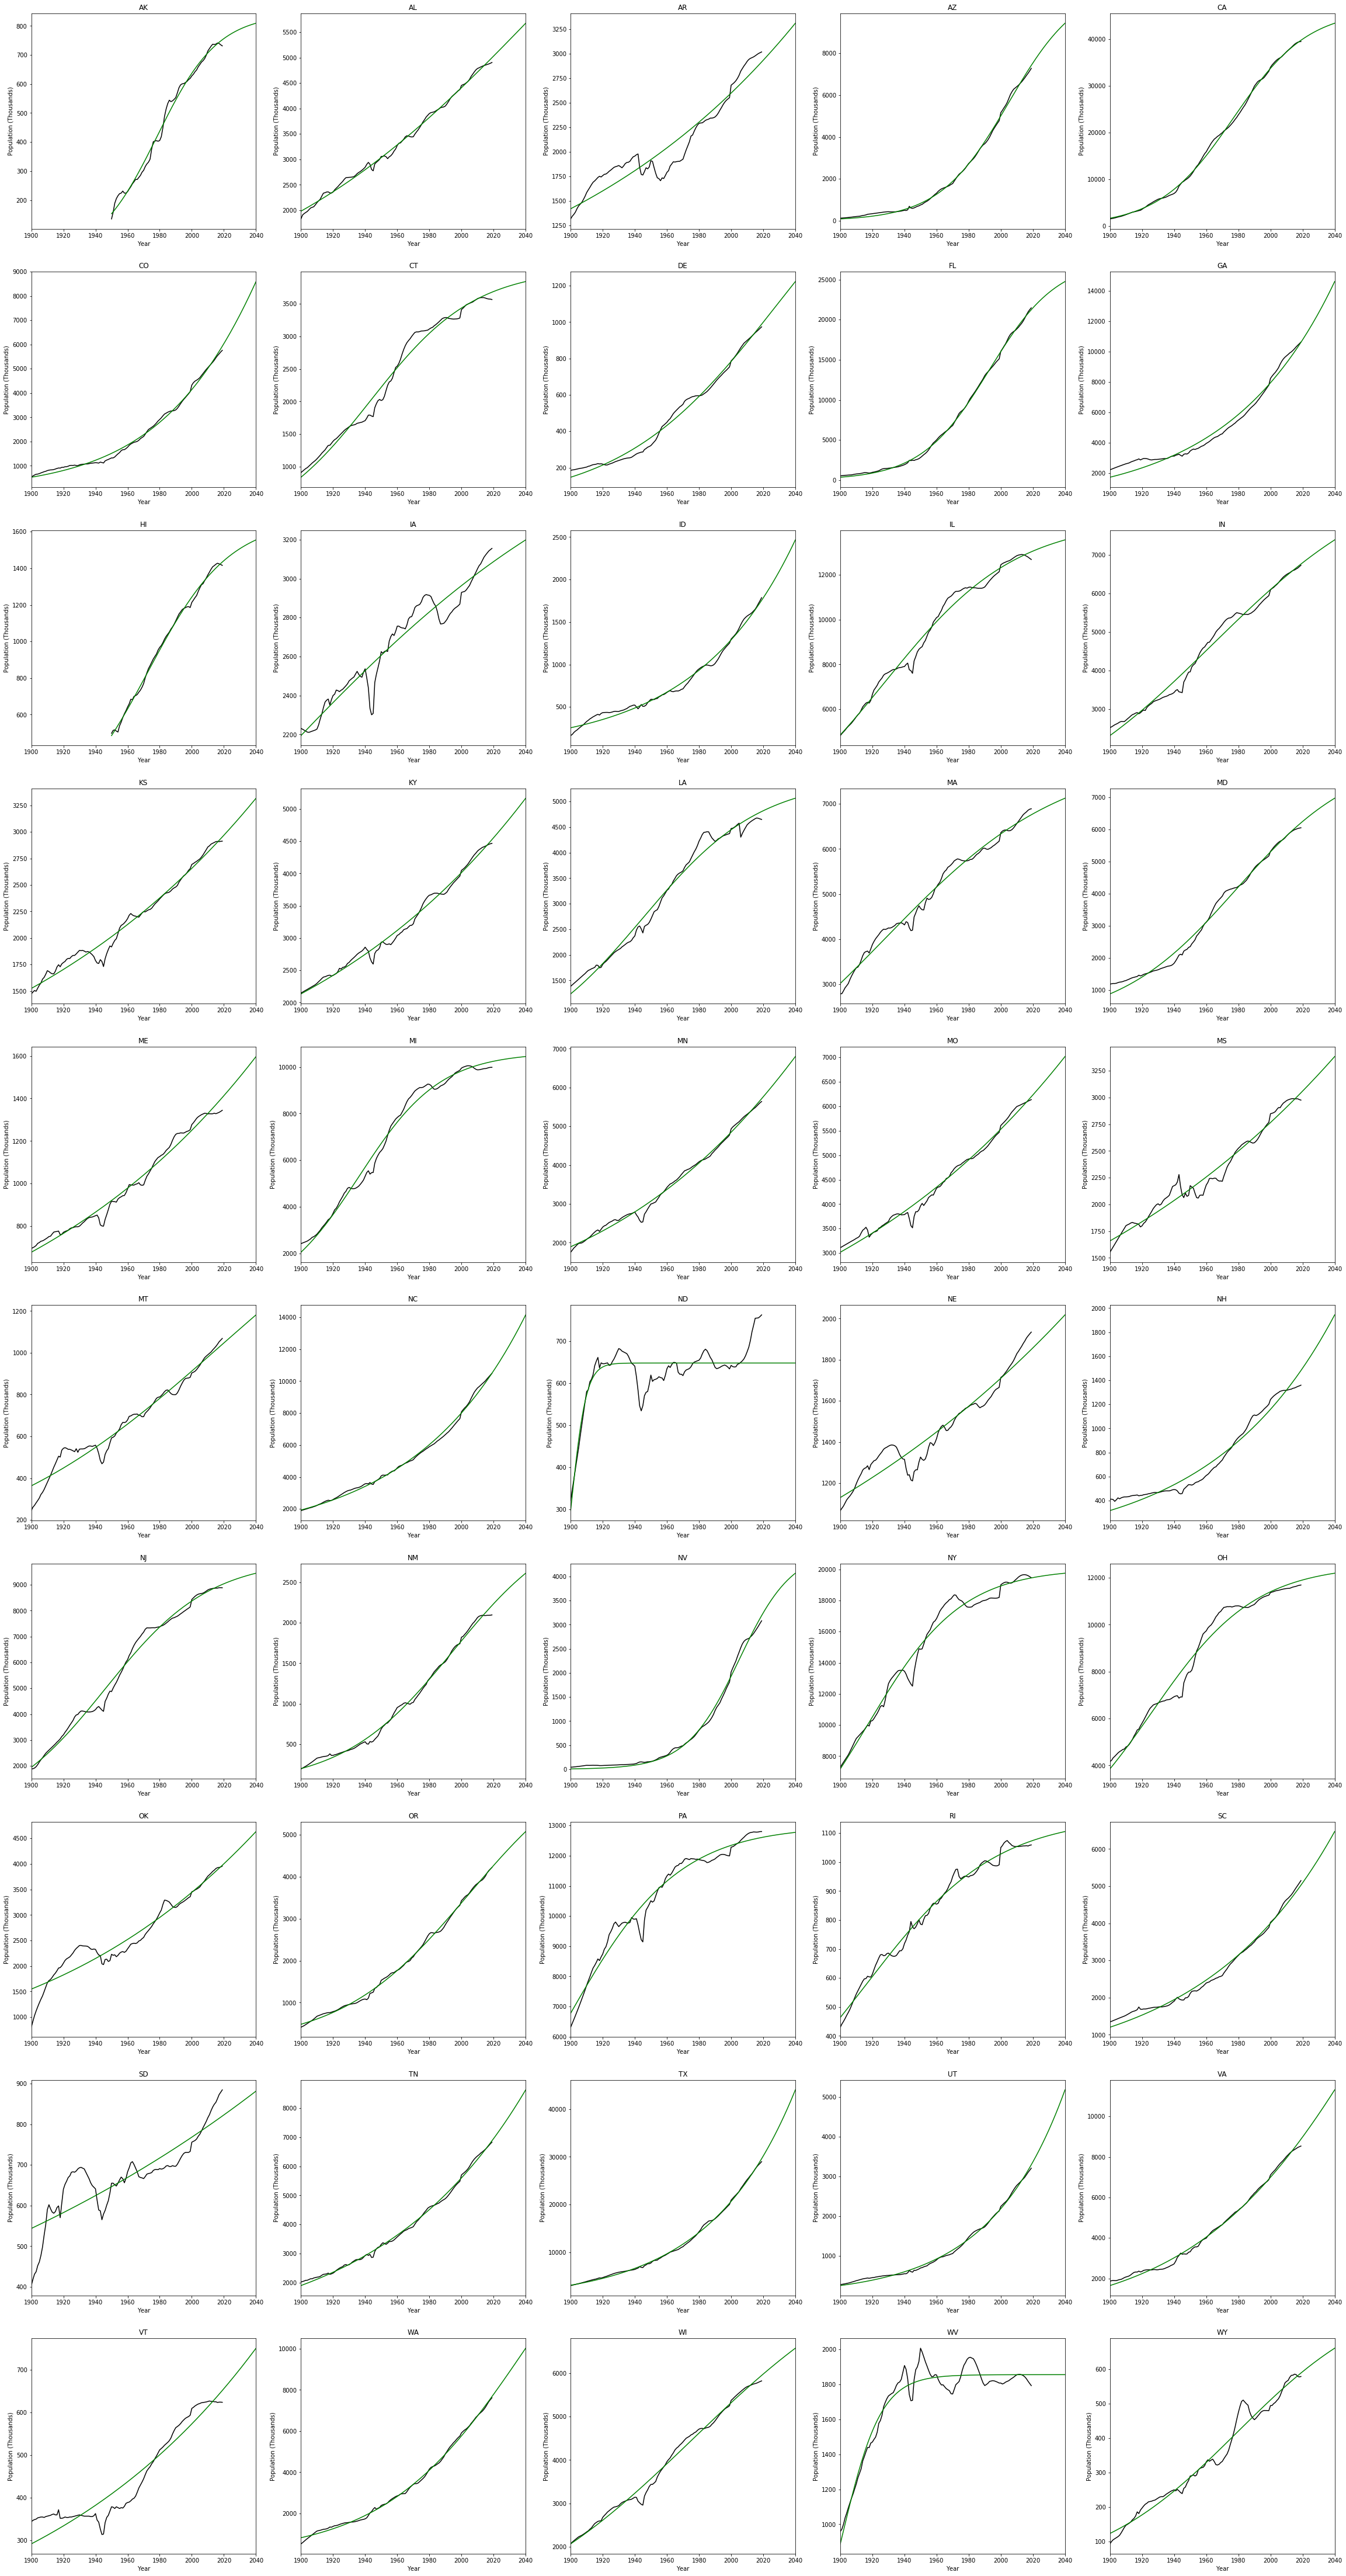

In [447]:
shape = (10, 5)
fig, ax = plt.subplots(shape[0], shape[1], figsize=(40, 80))
for i in range(len(senate_proj.columns)):
    axi = ax[np.unravel_index(i, shape)]
    state = senate_proj.columns[i]
    df = pop[state].dropna()
    df.plot(ax=axi, color='k')
    pop_proj[state].plot(ax=axi, color='g')
    axi.set_title(state)
#     axi.grid()
    axi.set_xlabel('Year')
    axi.set_ylabel('Population (Thousands)')

In [448]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 16))
# pop['US'].plot(ax=ax[0], color='b')
# pop_proj['US'].plot(ax=ax[0], color='r')
# s = pop_proj.drop('US', axis=1).sum(axis=1)
# s.plot(ax=ax[0], color='g')
# ax[0].grid()
# ax[0].set_title('US Population Projection')
# ax[1].set_xlabel('Year')
# ax[1].set_ylabel('Population (Thousands)')

# df = 100.0*(pop_proj['US'] - s)/pop_proj['US']
# df.plot(ax=ax[1])
# ax[1].grid()
# ax[1].set_title('US Population Error')
# ax[1].set_xlabel('Year')
# ax[1].set_ylabel('Error (%)')

In [449]:
# parties = ['Democrat', 'Tossup', 'Republican']
# color = (cmap(0.0), cmap(0.25), cmap(0.5))
# t = 5.0

# fig, ax = plt.subplots(3, 1, figsize=(12, 24))
# party_proj = pd.DataFrame(index=senate_proj.index, columns=parties)
# for year in party_proj.index:
#     party_proj['Democrat'].loc[year] = pop_proj[senate_proj.columns[senate_proj.loc[year] > t]].loc[year].sum()
#     party_proj['Tossup'].loc[year] = pop_proj[senate_proj.columns[np.abs(senate_proj.loc[year]) <= t]].loc[year].sum()
#     party_proj['Republican'].loc[year] = pop_proj[senate_proj.columns[senate_proj.loc[year] < -t]].loc[year].sum()

# party_proj.plot.area(ax=ax[0], color=color)
# ax[0].set_title('Population By Party')
# ax[0].set_xlabel('Year')
# ax[0].set_ylabel('Population (Thousands)')

# party_proj.divide(party_proj.sum(axis=1), axis=0).plot.area(ax=ax[1], color=color)
# ax[1].set_title('Population Fraction By Party')
# ax[1].set_xlabel('Year')
# ax[1].set_ylabel('Population Fraction')

# party_proj.plot(ax=ax[2], color=color)
# ax[2].grid()
# ax[2].set_title('Population By Party')
# ax[2].set_xlabel('Year')
# ax[2].set_ylabel('Population (Thousands)')

In [450]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 16))
# seat_proj = pd.DataFrame(index=senate_proj.index, columns=parties)
# for year in seat_proj.index:
#     seat_proj['Democrat'].loc[year] = 2.0*np.sum(senate_proj.loc[year] > t)
#     seat_proj['Tossup'].loc[year] = 2.0*np.sum(np.abs(senate_proj.loc[year]) <= t)
#     seat_proj['Republican'].loc[year] = 2.0*np.sum(senate_proj.loc[year] < -t)

# seat_proj.plot.area(ax=ax[0], color=color)
# ax[0].set_title('Seats By Party')
# ax[0].set_xlabel('Year')
# ax[0].set_ylabel('Seats')

# seat_proj.plot(ax=ax[1], color=color)
# ax[1].grid()
# ax[1].set_title('Seats By Party')
# ax[1].set_xlabel('Year')
# ax[1].set_ylabel('Seats')

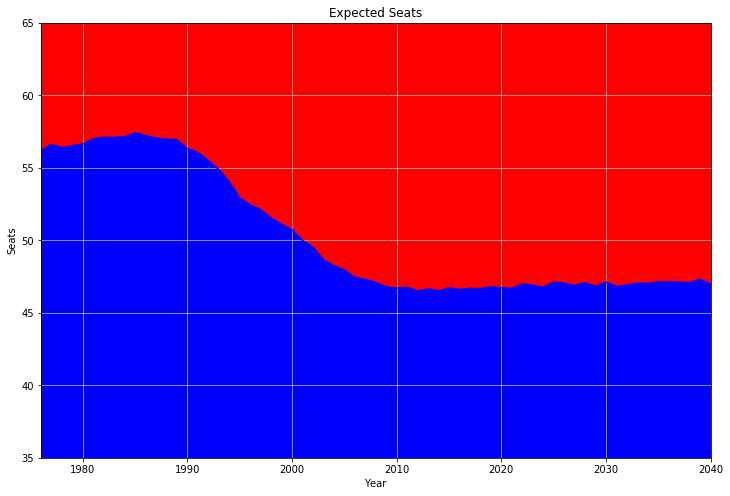

In [451]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
seat_prob = (2.0*senate_prob/100.0).sum(axis=1)

seat_prob.plot.area(ax=ax, color='b')
ax.set_title('Expected Seats')
ax.set_xlabel('Year')
ax.set_ylabel('Seats')
ax.set_facecolor('r')
ax.set_ylim([35, 65])
ax.grid()

In [452]:
# n = 100
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# seat_comp = pd.Series(index=senate_proj.index)
# for year in seat_proj.index:
#     x = np.zeros(n)
#     for i in range(n):
#         x[i] = 2.0*(np.random.uniform(size=len(senate_proj.columns)) <= senate_prob.loc[year]/100.0).astype(int).sum()
#     seat_comp[year] = np.mean(x)
#     pass

# seat_comp.plot.area(ax=ax, color='b')
# ax.set_title('Seat Composition By Party')
# ax.set_xlabel('Year')
# ax.set_ylabel('Seats')
# ax.set_facecolor('r')
# ax.set_ylim([35, 65])
# ax.grid()

In [453]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# party_proj.divide(seat_proj).plot(ax=ax, color=color)
# ax.grid()
# ax.set_title('Population Per Seat')
# ax.set_xlabel('Year')
# ax.set_ylabel('Population (Thousands)')

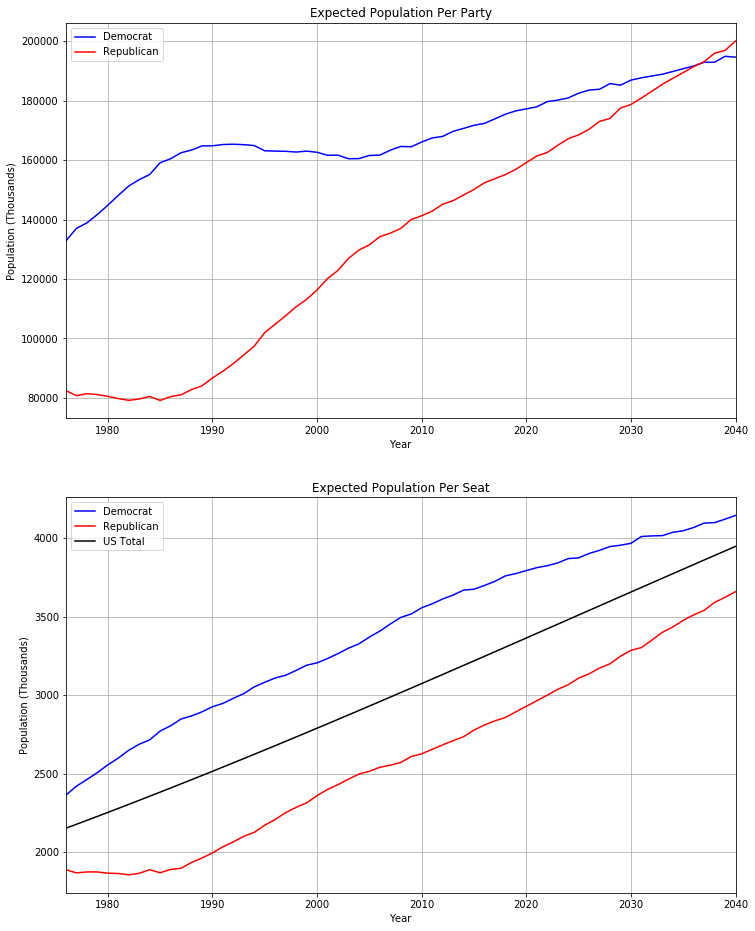

In [457]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16))
df = pop_proj.multiply(senate_prob/100.0).dropna(how='all').sum(axis=1)
df.plot(ax=ax[0], color='b', label='Democrat')
(pop_proj['US'].loc[df.index] - df).plot(ax=ax[0], color='r', label='Republican')
ax[0].grid()
ax[0].set_title('Expected Population Per Party')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Population (Thousands)')
ax[0].legend()
# ax[0].set_ylim(0, 250000)
df.divide(seat_prob).plot(ax=ax[1], color='b', label='Democrat')
(pop_proj[senate_prob.columns].sum(axis=1) - df).dropna(how='all').divide(100.0 - seat_prob).plot(ax=ax[1], color='r', label='Republican')
(pop_proj['US']/100.0).loc[df.index].plot(ax=ax[1], color='k', label='US Total')
ax[1].grid()
ax[1].set_title('Expected Population Per Seat')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Population (Thousands)')
ax[1].legend()
# ax[1].set_ylim(0, 5000)

In [455]:
# print('Tossup States')
# for year in senate_proj.index:
#     cols = list(senate_proj.columns[np.abs(senate_proj.loc[year]) <= t])
#     print('%d: %s' % (year, ', '.join(cols)))

In [456]:
t = 25.0
print('Tossup States')
for year in senate_prob.index:
    cols = list(senate_prob.columns[senate_prob.loc[year].apply(lambda x: (x <= 50 + t) & (x >= 50 - t))])
    print('%d: %s' % (year, ', '.join(cols)))

Tossup States
1976: AZ, CA, CT, DE, IA, ME, RI, TX, WY
1977: AZ, CA, CT, DE, IA, ME, MN, RI, SC, TX, WY
1978: AZ, CA, CT, DE, IA, ME, MN, SC, TX
1979: AZ, CA, CT, DE, ME, MN, SC, TX
1980: AZ, CA, CT, DE, ME, MN, SC, TX, VT
1981: AZ, CA, DE, ME, MN, SC, TX, VT
1982: AZ, CA, DE, ME, MN, SC, TX, VT
1983: CA, DE, ME, MN, SC, TX, VT
1984: CA, DE, ME, MN, SC, TX, VT
1985: ME, MN, SC, TX, VT
1986: ME, MN, SC, TX, VT
1987: ME, MN, SC, VT
1988: ME, MN, SC, TN, VT
1989: ME, MN, OK, SC, TN, VT
1990: MN, OK, SC, TN
1991: MN, OK, SC, TN
1992: AL, MN, NM, OK, TN
1993: AL, NE, NM, OK, TN
1994: AL, NE, NM, OK, TN
1995: AL, NE, NM, OH
1996: NE, NM, OH, OR
1997: KY, NE, NM, OH, OR
1998: KY, NE, NM, OH, OR
1999: GA, KY, NE, NM, OH, OR, VA
2000: GA, KY, NM, OH, SD, VA
2001: GA, KY, ND, NM, OH, SD, VA
2002: CO, FL, GA, ND, NM, OH, SD, VA
2003: CO, FL, GA, LA, ND, NV, SD, VA
2004: AR, CO, FL, LA, ND, NV, SD, VA
2005: AR, CO, FL, LA, ND, NV, PA, SD, VA
2006: AR, CO, FL, LA, ND, NV, PA, SD, VA
2007: AR, CO, F